In [50]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import pathlib
from tensorflow.keras.preprocessing import image
import visualkeras as vk

In [2]:
path = pathlib.Path("/Users/hanliu/Desktop/mask_detection")

In [3]:
#data overview
print('image with mask:',len(os.listdir(path/'yes')))
print('image without mask:',len(os.listdir(path/'no')))

image with mask: 1188
image without mask: 1200


In [4]:
batch_size = 64
epochs = 30
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [5]:
#split data into training (80%) and validation (20%) 
#data augmentation for the training set
train_aug_gen = ImageDataGenerator(
                    validation_split=0.2, 
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

In [6]:
valid_imagegen = ImageDataGenerator(validation_split=0.2,       
                                   rescale = 1./255)            
                                   

In [7]:
train_generator = train_aug_gen.flow_from_directory(
                                path,
                                target_size = (IMG_HEIGHT, IMG_WIDTH),
                                batch_size = batch_size,
                                color_mode="rgb",               
                                class_mode = 'binary',
                                seed=1377,                      # to make the result reproducible
                                subset = 'training') 

Found 1911 images belonging to 2 classes.


In [8]:
validation_generator = valid_imagegen.flow_from_directory(
                                path,
                                target_size = (IMG_HEIGHT, IMG_WIDTH),
                                batch_size = batch_size,
                                color_mode="rgb",               
                                class_mode = 'binary',
                                subset = 'validation') 

Found 477 images belonging to 2 classes.


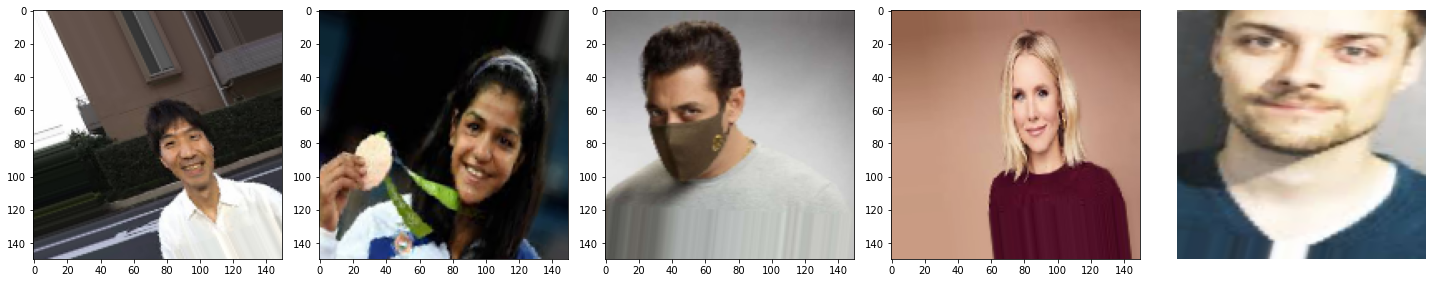

[0. 0. 1. 0. 0.]


In [9]:
#display 5 images in the training set randomly
sample_training_images, lables = next(train_generator)
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
         ax.imshow(img)
    ax.axis('off') 
    plt.tight_layout()
    plt.show()
plotImages(sample_training_images[:5]) 
print(lables[:5])              # 0 is without mask; 1 is with mask

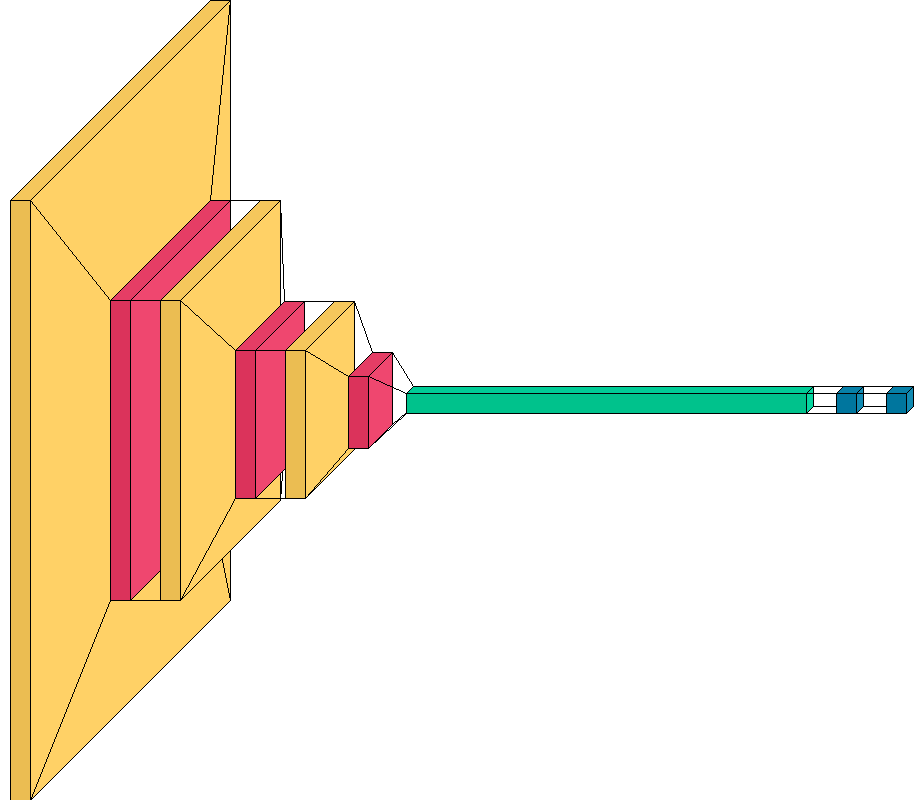

In [49]:
#create model layers
model = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3),activation='relu',padding='same',input_shape=(IMG_HEIGHT,
IMG_WIDTH,3)),
                    MaxPooling2D(pool_size=(2,2), strides=2),
                    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding= 'same'),
                    MaxPooling2D(pool_size=(2,2), strides =2),
                    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding= 'same'),
                    MaxPooling2D(pool_size=(2,2), strides =2),
                    Flatten(),
                    Dense(units=128, activation= 'relu'),
                    Dense(1), 

])
vk.layered_view(model, spacing=30)

In [15]:
#compile the model and check out model summary 
optimizer = tf.keras.optimizers.Adam(lr=0.0005)
model.compile(optimizer=optimizer,            
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

In [16]:
#train the model
history = model.fit_generator(
    train_generator,
    epochs = 30,
    validation_data= validation_generator)

Epoch 1/30
30/30 [==============================] - 100s 3s/step - loss: 0.6091 - accuracy: 0.6410 - val_loss: 0.5210 - val_accuracy: 0.6960
Epoch 2/30
30/30 [==============================] - 97s 3s/step - loss: 0.5452 - accuracy: 0.7091 - val_loss: 0.4937 - val_accuracy: 0.7421
Epoch 3/30
30/30 [==============================] - 96s 3s/step - loss: 0.5301 - accuracy: 0.7043 - val_loss: 0.5191 - val_accuracy: 0.7358
Epoch 4/30
30/30 [==============================] - 96s 3s/step - loss: 0.5239 - accuracy: 0.7206 - val_loss: 0.5291 - val_accuracy: 0.6960
Epoch 5/30
30/30 [==============================] - 96s 3s/step - loss: 0.5235 - accuracy: 0.7200 - val_loss: 0.5260 - val_accuracy: 0.7002
Epoch 6/30
30/30 [==============================] - 96s 3s/step - loss: 0.5241 - accuracy: 0.7190 - val_loss: 0.4887 - val_accuracy: 0.7841
Epoch 7/30
30/30 [==============================] - 123s 4s/step - loss: 0.5349 - accuracy: 0.7064 - val_loss: 0.4847 - val_accuracy: 0.7589
Epoch 8/30
30/30 [

In [14]:
model.save('train_model.h5')

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

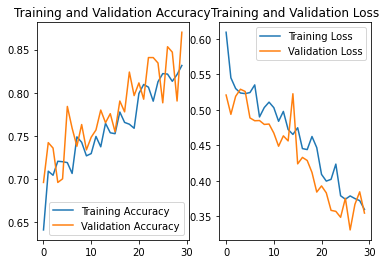

In [18]:
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show() 

In [35]:
path_test = pathlib.Path("/Users/yejin/Desktop/Test_image")

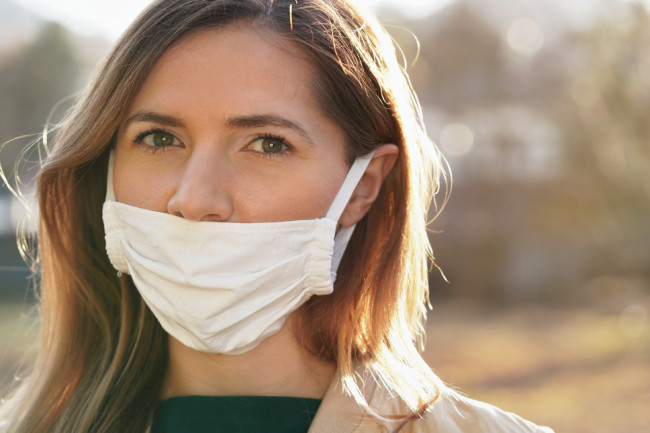

The person is wearing a mask.


In [53]:
from IPython.display import Image, display
#Test a new image
img_dir = path_test/'25.png'
img = image.load_img(img_dir, target_size = (150,150))
img = image.img_to_array(img)/255
img = tf.expand_dims(img, axis = 0)

display(Image(img_dir,width=150,height=150))
prediction=model.predict(img)

if(int(prediction[0][0]) == 0):
    print( "The person is wearing a mask.")
else:
    print( "The person is not wearing a mask.")
   


In [ ]:
import cv2
import os
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np

cascPath = "/Users/hanliu/Downloads/haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(cascPath)
model = load_model("train_model.h5")

video_capture = cv2.VideoCapture(0)
while True:
    # Capture frame-by-frame
    
    ret, frame = video_capture.read()
    frame = cv2.flip(frame,1,1)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray,
                                         scaleFactor=1.1,
                                         minNeighbors=5,
                                         minSize=(60, 60),
                                         flags=cv2.CASCADE_SCALE_IMAGE)
    faces_list=[]
    preds=[]
    for (x, y, w, h) in faces:
        face_frame = frame[y:y+h,x:x+w]
        face_frame = cv2.cvtColor(face_frame, cv2.COLOR_BGR2RGB)
        face_frame = cv2.resize(face_frame, (150,150))
        face_frame = img_to_array(face_frame)
        face_frame = np.expand_dims(face_frame, axis=0)
        face_frame =  preprocess_input(face_frame)
        faces_list.append(face_frame)
        if len(faces_list)>0:
            preds = model.predict(faces_list)
        for pred in preds:
            (mask, withoutMask) = pred
        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
        cv2.putText(frame, label, (x, y- 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)

        cv2.rectangle(frame, (x, y), (x + w, y + h),color, 2)
       
    cv2.imshow('Video', frame)
    key = cv2.waitKey(10)
     
    if key == 27: #The Esc key
        break